In [1]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix_percent(cm, labels, title, cmap):
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=labels)
    disp.plot(cmap=cmap, values_format=".1f")
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# H3BERTA

2025-10-14 14:08:01.342064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760443681.355720 4020728 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760443681.359827 4020728 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760443681.373209 4020728 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760443681.373223 4020728 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760443681.373225 4020728 computation_placer.cc:177] computation placer alr

Embedding train...
           0                   1    2
0   VRC42.02  AREATEGWLAKPVGALGV  BRO
1  561_01_55  ARDPFGDMYPHYNYHMDV  BRO
Embedding val...
                      0                        1    2
0  HEALTHY_IGG_35588116   ARHVVIRDFWSGPQGYYYYMDV  NON
1                  SF10  GRVGPGGLFDRWTGYHGHKWVDA  BRO
Embedding test...
                      0                     1    2     3        4      5  \
0  HEALTHY_IGG_91086192  ARDGHGSNSYSPYYYYYMDV  NON   0.0    (0/0)    NaN   
1             PCIN77B1b       TTHLSSRDFSWSWDP  BRO  65.0  (26/40)  human   

        6       7   8  
0     NaN     NaN   0  
1  88.889  catnap  40  
=== Validation ===
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       1.00      0.83      0.91        18

    accuracy                           0.92        36
   macro avg       0.93      0.92      0.92        36
weighted avg       0.93      0.92      0.92        36



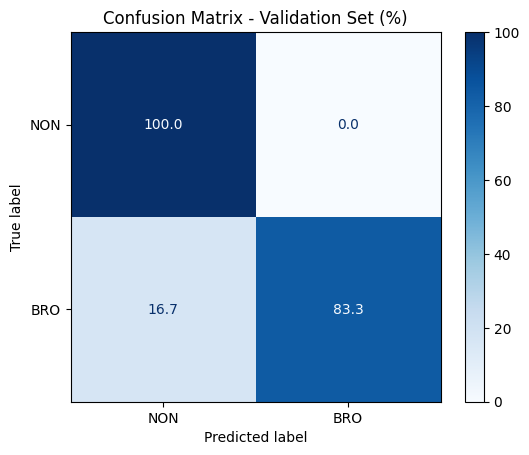

=== Test ===
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.95      0.90      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



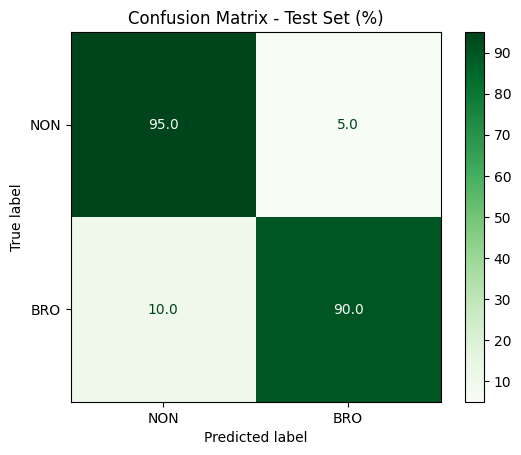

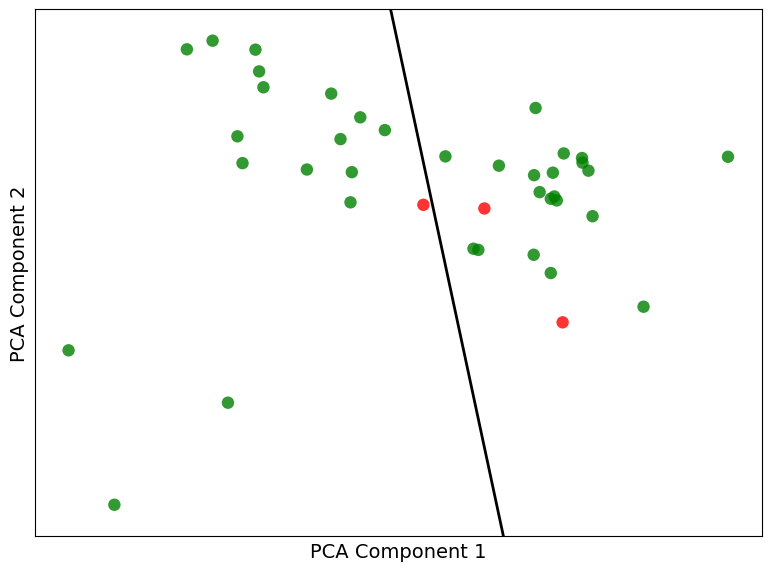

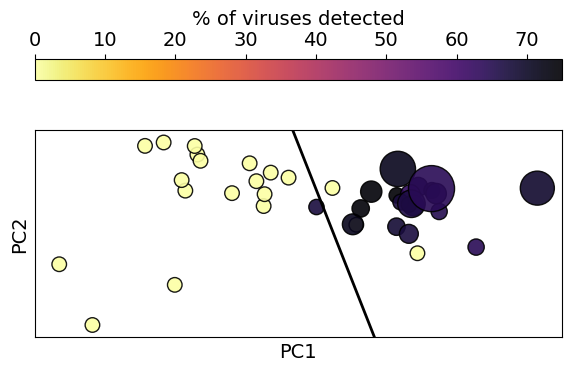

In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === PATH DEI FILE ===
train_path = '/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/data/V1_LINCLUST/TRAINING_DATASET/NOIMV/label_train_shuffled_BRONON.txt'
val_path   = '/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/data/V1_LINCLUST/TRAINING_DATASET/NOIMV/label_val_shuffled_BRONON.txt'
#test_path  = '/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/data/V1_LINCLUST/TRAINING_DATASET/NOIMV/label_test_shuffled_BRONON.txt'
test_path = 'label_test_shuffled_BRONON_neutralization_info.txt' #with neut info
# === MODELLO ===
model_name = "/ibmm_data/rodelc/DALM/LM/HEAVY/CDRH3/HEALTHY/P3-pipelines/model/SUB-PIPELINE1:IgG_IgA_Bsources/config3.json_lr5e-5_bs1024/BEST_MODEL/epoch_113/hf/"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model = AutoModel.from_pretrained(model_name)
model.eval()

# === FUNZIONE PER EMBEDDING MEDIO ===
def get_embedding(sequence):
    sequence = ''.join(list(sequence))  # spazio tra amaminoacidiinoacidi
    #print(sequence)aminoacidi
    inputs = tokenizer(sequence, return_tensors='pt', padding='max_length', truncation=True, max_length=100)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state.squeeze(0)
    attention_mask = inputs['attention_mask'].squeeze(0).bool()
    mean_embedding = last_hidden[attention_mask].mean(dim=0).numpy()
    return mean_embedding

# === FUNZIONE PER CARICARE DATI E CREARE EMBEDDING ===
def load_and_embed(path):
    df = pd.read_csv(path, sep=',', header=None)
    print(df.head(2))
    sequences = df.iloc[:, 1].tolist()
    label_map = {"BRO": 1, "NON": 0}  # mappa stringhe → numeri
    labels = df.iloc[:, 2].map(label_map).tolist()
    embeddings = np.array([get_embedding(seq) for seq in sequences])
    return embeddings, np.array(labels)

# === FUNZIONE PER CARICARE DATI, CREARE EMBEDDING E DUE FEATURE ===
def load_and_embed_test_set(path):
    # 1) Leggi il file
    df = pd.read_csv(path, sep=',', header=None)
    print(df.head(2))

    sequences = df.iloc[:, 1].tolist()
    label_map = {"BRO": 1, "NON": 0}  # mappa stringhe → numeri
    labels = df.iloc[:, 2].map(label_map).tolist()
    embeddings = np.array([get_embedding(seq) for seq in sequences])
    assay_size =  df[8].values
    perc_of_detection =  df[3].values
    return embeddings, labels, assay_size, perc_of_detection


# === CARICAMENTO ED EMBEDDING ===
print("Embedding train...")
X_train, y_train = load_and_embed(train_path)
print("Embedding val...")
X_val, y_val = load_and_embed(val_path)
print("Embedding test...")
X_test, y_test, assay_size, perc_of_detection = load_and_embed_test_set(test_path)

# === CLASSIFICAZIONE CON SVM ===
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

# === VALIDATION ===
print("=== Validation ===")
val_preds = clf.predict(X_val)
print(classification_report(y_val, val_preds))

cm_val = confusion_matrix(y_val, val_preds)
plot_confusion_matrix_percent(cm_val, labels=["NON", "BRO"], title="Confusion Matrix - Validation Set (%)", cmap='Blues')

# === TEST ===
print("=== Test ===")
test_preds = clf.predict(X_test)
print(classification_report(y_test, test_preds))

cm_test = confusion_matrix(y_test, test_preds)
plot_confusion_matrix_percent(cm_test, labels=["NON", "BRO"], title="Confusion Matrix - Test Set (%)", cmap='Greens')

from plot_utils import SVM_plot_assay_scatter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === 1. PCA del test set ===
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# === 2. Proietta anche i pesi dell'SVM nel piano PCA ===
# clf: SVM addestrato in 1024D, clf.coef_: shape (1, 1024)
w = clf.coef_.flatten()  # shape: (1024,) 
w_pca = pca.components_ @ w  # proiezione del vettore dei pesi nel nuovo spazio 2D
b = clf.intercept_[0]
# w_pca: è il vettore normale alla boundary nel nuovo spazio 2D.

# === 3. Calcola decision boundary nel piano PCA ===
# Troviamo punti (x, y) tali che w_pca · [x, y] + b = 0

# Crea meshgrid
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = w_pca[0] * xx + w_pca[1] * yy + b
Z = Z.reshape(xx.shape)

# === 4. Predizioni corrette / sbagliate ===
y_pred = clf.predict(X_test)
correct = y_pred == y_test
colors = np.where(correct, 'green', 'red')

# === 5. Plot ===
plt.figure(figsize=(8, 6))
plt.rcParams.update({
    'font.size':16,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)  # decision boundary
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, edgecolors='none', alpha=0.8, s =80)
#plt.title("Decision boundary Test Set (PCA 2D) - H3BERTa EMBEDDINGS")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.savefig('decision_boundary.png', dpi=300)
plt.show()

# for paper
output_prefix = 'H3BERTA_SVM_scatter_assay'
SVM_plot_assay_scatter(assay_size, xx, yy, Z, X_test_pca, perc_of_detection,output_prefix)



##### rain repertoire

=== Test ===
Embedding test...
                          0                          1    2    3
0  M-3849-G1-K-B3-2208-P3-1          AIASSQWKRVSTIGGDY  NON  UNK
1    M-99-G1-K-B3-2208-P3-1  ARVTPDQWLHFGESWGMFYYNGIDV  NON  UNK
              precision    recall  f1-score   support

           0       1.00      0.69      0.82     15541
           1       0.00      1.00      0.00         2

    accuracy                           0.69     15543
   macro avg       0.50      0.84      0.41     15543
weighted avg       1.00      0.69      0.82     15543



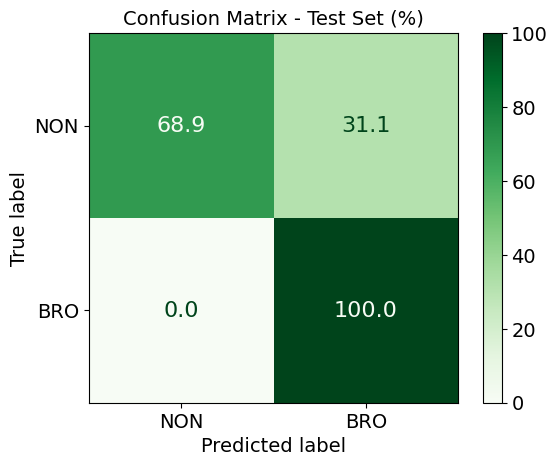

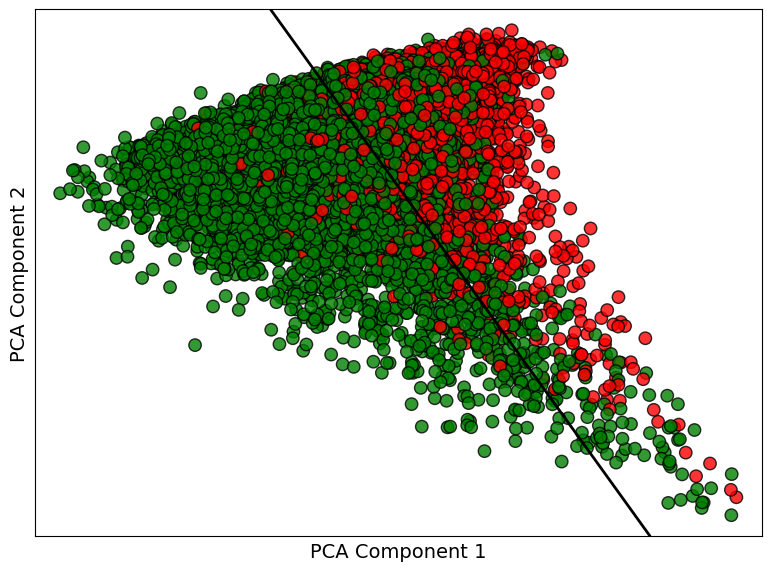

In [3]:
test_path = '/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/data/SOTA:RAIN/donor3(bnabs)/donor3_repertoire_uniqueCDRH3_seq_label.csv'
# === TEST ===
print("=== Test ===")
print("Embedding test...")
X_test, y_test = load_and_embed(test_path)
test_preds = clf.predict(X_test)
print(classification_report(y_test, test_preds))

cm_test = confusion_matrix(y_test, test_preds)
plot_confusion_matrix_percent(cm_test, labels=["NON", "BRO"], title="Confusion Matrix - Test Set (%)", cmap='Greens')
import joblib

# Salva tutto in un dizionario
results = {
    "X_test": X_test,
    "y_test": y_test,
    "test_preds": test_preds,
    "classification_report": classification_report(y_test, test_preds, output_dict=True),
    "confusion_matrix": cm_test
}

# Salva su disco
joblib.dump(results, "h3berta_svm_raindono3.pkl")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === 1. PCA del test set ===
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# === 2. Proietta anche i pesi dell'SVM nel piano PCA ===
# clf: SVM addestrato in 1024D, clf.coef_: shape (1, 1024)
w = clf.coef_.flatten()  # shape: (1024,) 
w_pca = pca.components_ @ w  # proiezione del vettore dei pesi nel nuovo spazio 2D
b = clf.intercept_[0]
# w_pca: è il vettore normale alla boundary nel nuovo spazio 2D.

# === 3. Calcola decision boundary nel piano PCA ===
# Troviamo punti (x, y) tali che w_pca · [x, y] + b = 0

# Crea meshgrid
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = w_pca[0] * xx + w_pca[1] * yy + b
Z = Z.reshape(xx.shape)

# === 4. Predizioni corrette / sbagliate ===
y_pred = clf.predict(X_test)
correct = y_pred == y_test
colors = np.where(correct, 'green', 'red')

# === 5. Plot ===
plt.figure(figsize=(8, 6))
plt.rcParams.update({
    'font.size':16,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)  # decision boundary
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, edgecolors='k', alpha=0.8, s =80)
#plt.title("Decision boundary Test Set (PCA 2D) - H3BERTa EMBEDDINGS")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.savefig('decision_boundary.png', dpi=300)
plt.show()


from plot_utils import SVM_plot_assay_scatter

output_prefix = 'H3BERTA_SVM_scatter_raindonor3'
#SVM_plot_assay_scatter(assay_size, xx, yy, Z, X_test_pca, perc_of_detection,output_prefix)


# gan bert

Embedding train...
           0                   1    2
0   VRC42.02  AREATEGWLAKPVGALGV  BRO
1  561_01_55  ARDPFGDMYPHYNYHMDV  BRO
Embedding val...
                      0                        1    2
0  HEALTHY_IGG_35588116   ARHVVIRDFWSGPQGYYYYMDV  NON
1                  SF10  GRVGPGGLFDRWTGYHGHKWVDA  BRO
Embedding test...
                      0                     1    2     3        4      5  \
0  HEALTHY_IGG_91086192  ARDGHGSNSYSPYYYYYMDV  NON   0.0    (0/0)    NaN   
1             PCIN77B1b       TTHLSSRDFSWSWDP  BRO  65.0  (26/40)  human   

        6       7   8  
0     NaN     NaN   0  
1  88.889  catnap  40  
=== Validation ===
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.89      0.94      0.92        18

    accuracy                           0.92        36
   macro avg       0.92      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36



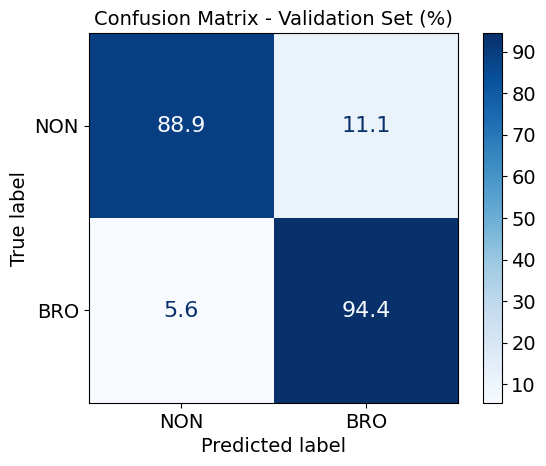

=== Test ===
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.95      0.90      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



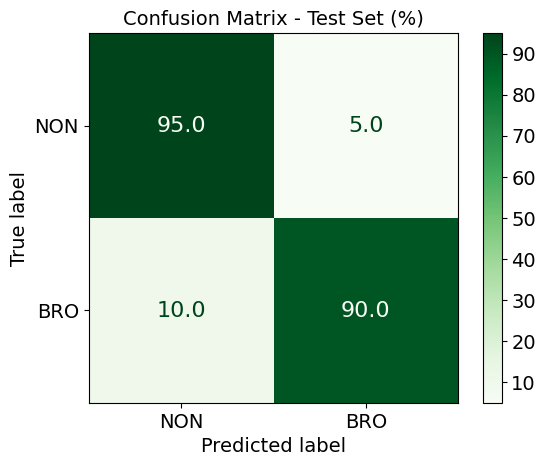

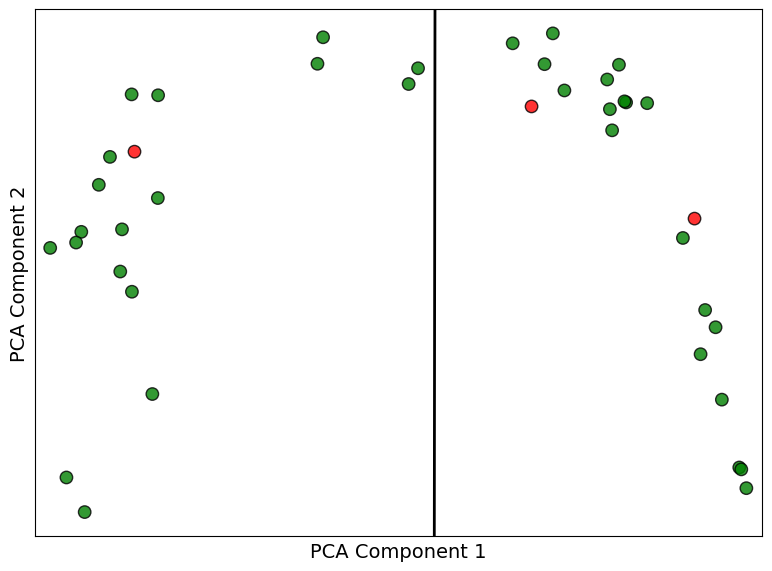

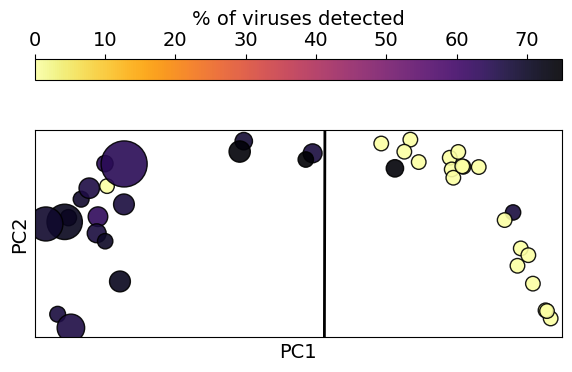

In [4]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# === PATH DEI FILE ===
train_path = '/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/data/V1_LINCLUST/TRAINING_DATASET/NOIMV/label_train_shuffled_BRONON.txt'
val_path   = '/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/data/V1_LINCLUST/TRAINING_DATASET/NOIMV/label_val_shuffled_BRONON.txt'
#test_path  = '/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/data/V1_LINCLUST/TRAINING_DATASET/NOIMV/label_test_shuffled_BRONON.txt'
test_path = 'label_test_shuffled_BRONON_neutralization_info.txt' #with neut info
# === MODELLO ===
model_name = "/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/GAN-BERT_TRAININGS/no_IMV/H3BERTA/BRO_NON_balanced/PAPER/PAPER_MODEL:batch_16_lrG_5e-5_lrD_5e-5_numLayersG_1_numLayersD_2_noiseSize_1000_dropout_0.1_data_4unlabel_data_shuffled.txt_balance_True/best_model/transformer"
tokenizer = AutoTokenizer.from_pretrained('/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/GAN-BERT-TOKENIZER', do_lower_case=False)
model = AutoModel.from_pretrained(model_name)
model.eval()

# === FUNZIONE PER EMBEDDING MEDIO ===
def get_embedding(sequence):
    sequence = ' '.join(list(sequence))  # spazio tra aminoacidi
    inputs = tokenizer(sequence, return_tensors='pt', padding='max_length', truncation=True, max_length=100)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state.squeeze(0)
    attention_mask = inputs['attention_mask'].squeeze(0).bool()
    mean_embedding = last_hidden[attention_mask].mean(dim=0).numpy()
    return mean_embedding

# === FUNZIONE PER CARICARE DATI E CREARE EMBEDDING ===
def load_and_embed(path):
    df = pd.read_csv(path, sep=',', header=None)
    print(df.head(2))
    sequences = df.iloc[:, 1].tolist()
    label_map = {"BRO": 1, "NON": 0}  # mappa stringhe → numeri
    labels = df.iloc[:, 2].map(label_map).tolist()
    embeddings = np.array([get_embedding(seq) for seq in sequences])
    return embeddings, np.array(labels)


# === FUNZIONE PER CARICARE DATI, CREARE EMBEDDING E DUE FEATURE ===
def load_and_embed_test_set(path):
    # 1) Leggi il file
    df = pd.read_csv(path, sep=',', header=None)
    print(df.head(2))

    sequences = df.iloc[:, 1].tolist()
    label_map = {"BRO": 1, "NON": 0}  # mappa stringhe → numeri
    labels = df.iloc[:, 2].map(label_map).tolist()
    embeddings = np.array([get_embedding(seq) for seq in sequences])
    assay_size =  df[8].values
    perc_of_detection =  df[3].values
    return embeddings, labels, assay_size, perc_of_detection


# === CARICAMENTO ED EMBEDDING ===
print("Embedding train...")
X_train, y_train = load_and_embed(train_path)
print("Embedding val...")
X_val, y_val = load_and_embed(val_path)
print("Embedding test...")
X_test, y_test, assay_size, perc_of_detection = load_and_embed_test_set(test_path)

# === CLASSIFICAZIONE CON SVM ===
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix_percent(cm, labels, title, cmap):
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=labels)
    disp.plot(cmap=cmap, values_format=".1f")
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# === VALIDATION ===
print("=== Validation ===")
val_preds = clf.predict(X_val)
print(classification_report(y_val, val_preds))

cm_val = confusion_matrix(y_val, val_preds)
plot_confusion_matrix_percent(cm_val, labels=["NON", "BRO"], title="Confusion Matrix - Validation Set (%)", cmap='Blues')

# === TEST ===
print("=== Test ===")
test_preds = clf.predict(X_test)
print(classification_report(y_test, test_preds))

cm_test = confusion_matrix(y_test, test_preds)
plot_confusion_matrix_percent(cm_test, labels=["NON", "BRO"], title="Confusion Matrix - Test Set (%)", cmap='Greens')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === 1. PCA del test set ===
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# === 2. Proietta anche i pesi dell'SVM nel piano PCA ===
# clf: SVM addestrato in 1024D, clf.coef_: shape (1, 1024)
w = clf.coef_.flatten()  # shape: (1024,) 
w_pca = pca.components_ @ w  # proiezione del vettore dei pesi nel nuovo spazio 2D
b = clf.intercept_[0]
# w_pca: è il vettore normale alla boundary nel nuovo spazio 2D.

# === 3. Calcola decision boundary nel piano PCA ===
# Troviamo punti (x, y) tali che w_pca · [x, y] + b = 0

# Crea meshgrid
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = w_pca[0] * xx + w_pca[1] * yy + b
Z = Z.reshape(xx.shape)

# === 4. Predizioni corrette / sbagliate ===
y_pred = clf.predict(X_test)
correct = y_pred == y_test
colors = np.where(correct, 'green', 'red')

# === 5. Plot ===
plt.figure(figsize=(8, 6))
plt.rcParams.update({
    'font.size':16,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)  # decision boundary
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, edgecolors='k', alpha=0.8, s =80)
#plt.title("Decision boundary Test Set (PCA 2D) - H3BERTa EMBEDDINGS")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.savefig('decision_boundary.png', dpi=300)
plt.show()


from plot_utils import SVM_plot_assay_scatter

output_prefix = 'GANBERT_SVM_scatter_assay'
SVM_plot_assay_scatter(assay_size, xx, yy, Z, X_test_pca, perc_of_detection,output_prefix)



##### rain donor 3 (12 minutes)

=== Test ===
Embedding test...
                          0                          1    2    3
0  M-3849-G1-K-B3-2208-P3-1          AIASSQWKRVSTIGGDY  NON  UNK
1    M-99-G1-K-B3-2208-P3-1  ARVTPDQWLHFGESWGMFYYNGIDV  NON  UNK
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     15541
           1       0.00      1.00      0.00         2

    accuracy                           0.72     15543
   macro avg       0.50      0.86      0.42     15543
weighted avg       1.00      0.72      0.84     15543



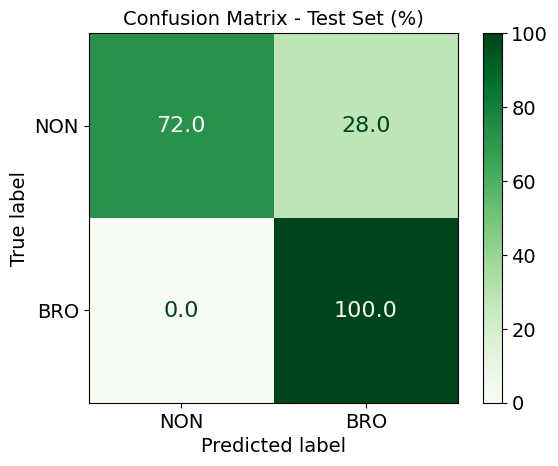

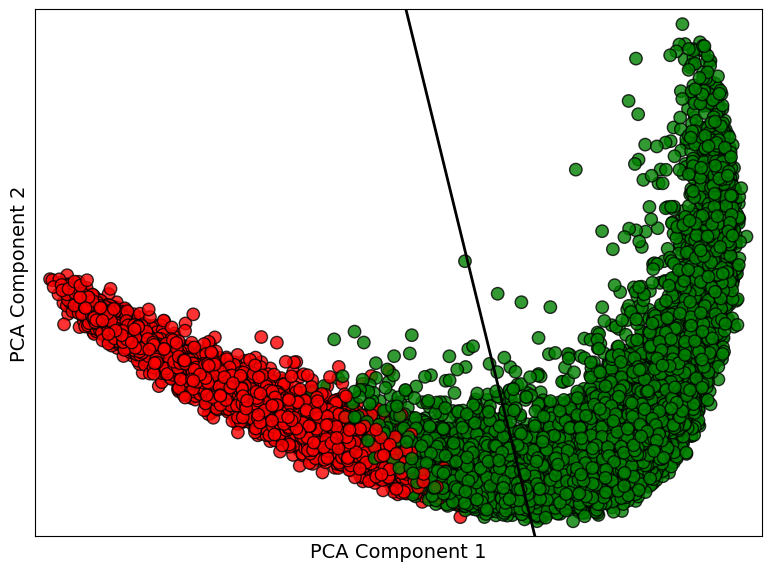

In [5]:
test_path = '/ibmm_data/rodelc/DALM/CLS_bnAbs/CDRH3/data/SOTA:RAIN/donor3(bnabs)/donor3_repertoire_uniqueCDRH3_seq_label.csv'
# === TEST ===
print("=== Test ===")
print("Embedding test...")
X_test, y_test = load_and_embed(test_path)
test_preds = clf.predict(X_test)
print(classification_report(y_test, test_preds))

cm_test = confusion_matrix(y_test, test_preds)
plot_confusion_matrix_percent(cm_test, labels=["NON", "BRO"], title="Confusion Matrix - Test Set (%)", cmap='Greens')
import joblib

# Salva tutto in un dizionario
results = {
    "X_test": X_test,
    "y_test": y_test,
    "test_preds": test_preds,
    "classification_report": classification_report(y_test, test_preds, output_dict=True),
    "confusion_matrix": cm_test
}

# Salva su disco
joblib.dump(results, "ganbert_svm_raindono3.pkl")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === 1. PCA del test set ===
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# === 2. Proietta anche i pesi dell'SVM nel piano PCA ===
# clf: SVM addestrato in 1024D, clf.coef_: shape (1, 1024)
w = clf.coef_.flatten()  # shape: (1024,) 
w_pca = pca.components_ @ w  # proiezione del vettore dei pesi nel nuovo spazio 2D
b = clf.intercept_[0]
# w_pca: è il vettore normale alla boundary nel nuovo spazio 2D.

# === 3. Calcola decision boundary nel piano PCA ===
# Troviamo punti (x, y) tali che w_pca · [x, y] + b = 0

# Crea meshgrid
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = w_pca[0] * xx + w_pca[1] * yy + b
Z = Z.reshape(xx.shape)

# === 4. Predizioni corrette / sbagliate ===
y_pred = clf.predict(X_test)
correct = y_pred == y_test
colors = np.where(correct, 'green', 'red')

# === 5. Plot ===
plt.figure(figsize=(8, 6))
plt.rcParams.update({
    'font.size':16,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)  # decision boundary
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, edgecolors='k', alpha=0.8, s =80)
#plt.title("Decision boundary Test Set (PCA 2D) - H3BERTa EMBEDDINGS")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.savefig('decision_boundary.png', dpi=300)
plt.show()


from plot_utils import SVM_plot_assay_scatter

output_prefix = 'GANBERT_SVM_scatter_raindonor3'
#SVM_plot_assay_scatter(assay_size, xx, yy, Z, X_test_pca, perc_of_detection,output_prefix)